# JupyLabBook @ SIRIUS

In [1]:
import CustomFunctions as CF
import FrontendFunctions as FF
import PyNexus as PN


import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
if 'is_HR' in locals():
    # Used to generate a high-resolution PDF
    set_matplotlib_formats('png', 'pdf')
    
class Experiment:
    """
    Class Experiment is used to pass arguments concerning the current experiment only.
    """
    def __init__(self):
        pass
    
expt = Experiment() 

# Necessary for saving in pdf
expt.notebook_name = 'JupyLabBook.ipynb'

# Directory where the data will be saved
expt.working_dir = "/Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/"

# Directory where the nexus files are 
expt.recording_dir = "/Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/recording/"

# Directory where the logs are
expt.logs_dir = "/Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/logs/"   


expt.wavelength = 0.155 # in nm
expt.thetac = 0.0028 # in rad

expt.moytocreate=(10, 20, 40)
expt.binsize=10
expt.nblevels=50

######################################
FF.Check_files(expt)

Versions of modules used:
CustomFunctions: 0.3
FrontendFunctions: 0.3
PyNexus: v4.1
Check that you are using the last versions of the modules and read the manual on: 
https://github.com/ArnaudHemmerle/JupyLabBook



In [2]:
scan = FF.Choose_action(expt)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### SIRIUS_2020_03_12_0756: continuous_ascan delta -24 -19 100 5


In [3]:
import PyNexus as PN
import numpy as np
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import time
import subprocess
import sys
import lmfit as L
from scipy.special import erf
from PIL import Image


In [58]:
# distance pilatus sample in mm
expt.distance = 435.5

# PONI: position of the direct beam in pixels (gamma = 0, delta = 0)
expt.pixel_PONI_x = 565
expt.pixel_PONI_y = 996.5

# pilatus pixel size in mm
expt.pixel_size = 0.172 

expt.wavelength = 12398./10260./10.

# detector angles in degrees
expt.delta = -11.578 #in the surface plane
expt.gamma = 0. #out of the surface plane

# incident angle in degrees
expt.thetai = 0.

expt.channel0 = 600.
expt.thetazfactor = 1.

In [32]:
import matplotlib.gridspec as gridspec
def Extract_pilatus_sum(nxs_filename='SIRIUS_test.nxs', working_dir='', recording_dir='', logz=True,
                        show_data_stamps=False, show_saved_data=False):
    
    """
    ADD 1D PLOT CUT INTEGRATION
    Extract, plot, and save the GIXS scan. 
    """
    
    nxs_path = recording_dir+nxs_filename

    if not os.path.isfile(nxs_path):
        print(PN._RED+'Scan %s seems not to exist in recording directory'%(nxs_filename)+PN._RESET)
        print(('\t\t recording directory : '+recording_dir))
    else:
        i_pilatus=None
        print(PN._BLUE+" - Open Nexus Data File :"+ PN._RESET)
        print('\t'+nxs_path)
        try:
            nexus=PN.PyNexusFile(nxs_path)
        except:
            print(PN._RED,'\t Nexus file seems not to exist or is not correct',PN._RESET)
            return
        nbpts=np.int(nexus.get_nbpts())
        print("\t. Number of data points: ", nbpts)
        # Get stamps
        stamps=nexus.extractStamps()
        if show_data_stamps : print("\t. Available Counters:")
        for i in range(len(stamps)):
            if stamps[i][1] is not None:
                if show_data_stamps : print("\t\t", i, ' -------> ', stamps[i][1])
                if stamps[i][1].lower()=='pilatus':
                    i_pilatus=i
            else:
                if show_data_stamps : print("\t\t",i, ' -------> ', stamps[i][0])
        
        
        # Check that Pilatus data are present (images)
        if i_pilatus is not None:
            print('\t. Pilatus data found, (column %d, alias %s)'%(i_pilatus, stamps[i_pilatus][1]))
        else:
            print(PN._RED,'\t. No pilatus data found', PN._RESET)
            nexus.close()
            return

        images = np.zeros([nbpts, 1043, 981])

        for i in range(nbpts):
            sys.stdout.write('Treat image %d/%d                                                                 \r'%(i+1, nbpts))
            sys.stdout.flush()

            #Extract the images from the nexus file
            stamp, image = nexus.extract_one_data_point(stamps[i_pilatus][0], i, verbose = False)

            #Remove the dead pixels

            image[877,528]=0.0
            image[922,847]=0.0
            image[1018,881]=0.0
            image[382,432]=0.0
            image[640,859]=0.0
            image[640,860]=0.0

            images[i,:] = image    
            
            sys.stdout.write('                                                                                  \r')
            sys.stdout.flush()

            
        images_sum = images.sum(axis=0)

        #Replace the dead zone (spacing between chips) on the detector with -2. 
        images_sum = np.where(images_sum>0, images_sum, -2.)

        #Plot the image to be saved

        #Choose the colormap
        #cmap = 'Greys'
        cmap = 'viridis'
        
        pixels_x = np.arange(0,np.shape(images_sum)[1],1)
        pixels_y = np.arange(0,np.shape(images_sum)[0],1)

        xx, yy = np.meshgrid(pixels_x, pixels_y)

              
        fig = plt.figure(figsize=(15,15))

        #Divide the grid in 2x2
        outer = gridspec.GridSpec(2, 2, wspace=0.2)

        #Divide the left row in 2x1
        inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                        subplot_spec=outer[0], hspace=0.5)

        #Plot a profile along y (integrated over x)
        ax1 = fig.add_subplot(inner[0])
        profile_y = images_sum.sum(axis=1)
        ax1.set_yscale('log')
        ax1.set(xlabel = 'vertical pixel (y)', ylabel = 'integration along x')
        ax1.plot(profile_y)

        #Plot a profile along x (integrated over y)
        ax2 = fig.add_subplot(inner[1])
        profile_x = images_sum.sum(axis=0)
        ax2.set_yscale('log')
        ax2.set(xlabel = 'horizontal pixel (x)', ylabel = 'integration along y')
        ax2.plot(profile_x)

        #Divide the right row in 1x1
        inner = gridspec.GridSpecFromSubplotSpec(1, 1,
                        subplot_spec=outer[1], wspace=0.1, hspace=0.1)

        #Show the full image integrated over the scan
        ax0 = fig.add_subplot(inner[0])
        if logz:
            ax0.pcolormesh(xx, yy, images_sum, cmap = cmap, norm = colors.LogNorm())
        else:
            ax0.pcolormesh(xx, yy, images_sum, cmap = cmap)
        ax0.set(xlabel = 'horizontal pixel (x)', ylabel ='vertical pixel (y)')
        ax0.invert_yaxis()
        fig.subplots_adjust(top=0.95)
        fig.suptitle(nxs_filename.split('\\')[-1], fontsize=16)
        plt.show()
        plt.close()

        # Create Save Name
        savename=working_dir+nxs_filename[:nxs_filename.rfind('.nxs')]
            
        np.savetxt(savename+'_pilatus_sum.mat', images_sum)

        im = Image.fromarray(images_sum)
        im.save(savename+'_pilatus_sum.tiff')

        if show_saved_data: 
            print('\t. Original matrix saved in:')
            print("\t\t", savename+'.mat')
            print(" ")
            print('\t. Tiff saved in:')
            print("\t\t", savename+'.tiff')
            print(" ")
        

 - Open Nexus Data File :
	/Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/recording/SIRIUS_2019_11_07_00325.nxs
	. Number of data points:  11
	. Available Counters:
		 0  ------->  hu36energy
		 1  ------->  current
		 2  ------->  mon2
		 3  ------->  mon4
		 4  ------->  camxdirect
		 5  ------->  pilatus
		 6  ------->  pilatusroi1
		 7  ------->  integration_time
		 8  ------->  sensorsRelTimestamps
		 9  ------->  sensorsTimestamps
	. Pilatus data found, (column 5, alias pilatus)


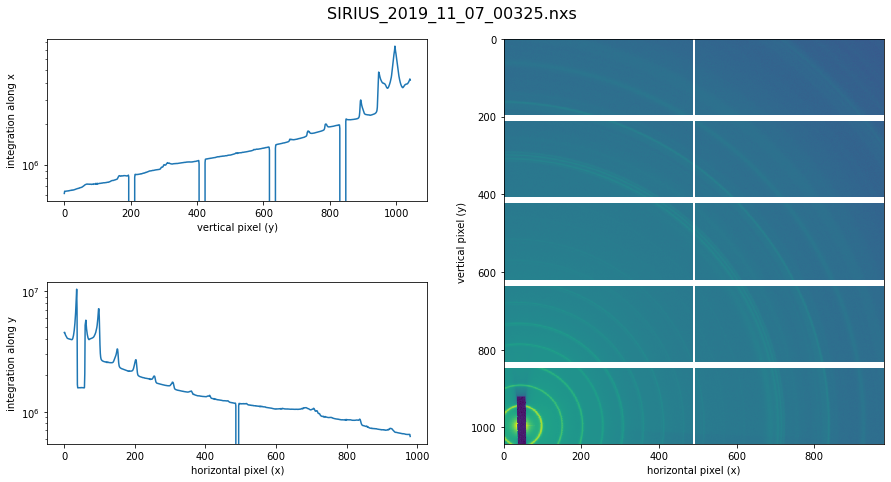

	. Original matrix saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.mat
 
	. Tiff saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.tiff
 


In [33]:
Extract_pilatus_sum(nxs_filename='SIRIUS_2019_11_07_00325.nxs', working_dir=expt.working_dir, recording_dir=expt.recording_dir,
                 logz=True,show_data_stamps=True, show_saved_data=True)

In [96]:
def Extract_GIXS(nxs_filename='SIRIUS_test.nxs', working_dir='', recording_dir='',
                 logz=True, wavelength=0.155, thetai=0.002, distance=2722, gamma = 0., delta = 0.,
                 pixel_PONI_x=490, pixel_PONI_y=975, pixel_size=0.172,
                 show_data_stamps=False, show_saved_data=False,
                 plot_twotheta_alphaf=False, plot_qxy_qz=False, plot_qxy_q=False):
    
    """
    ADD 1D PLOT CUT INTEGRATION
    Extract, plot, and save the GIXS scan. 
    """
    
    nxs_path = recording_dir+nxs_filename

    if not os.path.isfile(nxs_path):
        print(PN._RED+'Scan %s seems not to exist in recording directory'%(nxs_filename)+PN._RESET)
        print(('\t\t recording directory : '+recording_dir))
    else:
        i_pilatus=None
        print(PN._BLUE+" - Open Nexus Data File :"+ PN._RESET)
        print('\t'+nxs_path)
        try:
            nexus=PN.PyNexusFile(nxs_path)
        except:
            print(PN._RED,'\t Nexus file seems not to exist or is not correct',PN._RESET)
            return
        nbpts=np.int(nexus.get_nbpts())
        print("\t. Number of data points: ", nbpts)
        # Get stamps
        stamps=nexus.extractStamps()
        if show_data_stamps : print("\t. Available Counters:")
        for i in range(len(stamps)):
            if stamps[i][1] is not None:
                if show_data_stamps : print("\t\t", i, ' -------> ', stamps[i][1])
                if stamps[i][1].lower()=='pilatus':
                    i_pilatus=i
            else:
                if show_data_stamps : print("\t\t",i, ' -------> ', stamps[i][0])
        
        
        # Check that Pilatus data are present (images)
        if i_pilatus is not None:
            print('\t. Pilatus data found, (column %d, alias %s)'%(i_pilatus, stamps[i_pilatus][1]))
        else:
            print(PN._RED,'\t. No pilatus data found', PN._RESET)
            nexus.close()
            return

        images = np.zeros([nbpts, 1043, 981])

        for i in range(nbpts):
            sys.stdout.write('Treat image %d/%d                                                                 \r'%(i+1, nbpts))
            sys.stdout.flush()

            #Extract the images from the nexus file
            stamp, image = nexus.extract_one_data_point(stamps[i_pilatus][0], i, verbose = False)

            #Remove the dead pixels

            image[877,528]=0.0
            image[922,847]=0.0
            image[1018,881]=0.0
            image[382,432]=0.0
            image[640,859]=0.0
            image[640,860]=0.0

            images[i,:] = image    
            
            sys.stdout.write('                                                                                  \r')
            sys.stdout.flush()

            
        images_sum = images.sum(axis=0)

        #Replace the dead zone (spacing between chips) on the detector with -2. 
        images_sum = np.where(images_sum>0, images_sum, -2.)
        
        #Extract the values of each elements of the nxs
        s, data = nexus.extractData('0D')   

        i_gamma = None
        i_delta = None
        for i in range(len(stamps)):
            if (stamps[i][1] != None and stamps[i][1].lower()=='delta'):
                i_delta = i
            if (stamps[i][1] != None and stamps[i][1].lower()=='gamma'):
                i_gamma = i    

        if i_gamma != None:
            gamma = np.mean(data[i_gamma])
            print('\t. Gamma motor data found, mean value %3.4g deg'%(gamma))
        else:
            print(PN._RED,'\t. No gamma found, taking gamma =%3.4g'%(gamma), PN._RESET)
        if i_delta != None:
            delta = np.mean(data[i_delta])
            print('\t. Delta motor data found, mean value %3.4g deg'%(delta))
        else:
            print(PN._RED,'\t. No delta found, taking delta =%3.4g'%(delta), PN._RESET)


        print('\t. For more details on the geometry, see:')
        print('\t \t -Fig.2 in doi:10.1107/S0909049512022017')
        print('\t \t -Slide 4 in http://gisaxs.com/files/Strzalka.pdf')

        pixels_x = np.arange(0,np.shape(images_sum)[1],1)
        pixels_y = np.arange(0,np.shape(images_sum)[0],1)

        xx, yy = np.meshgrid(pixels_x, pixels_y)

        # alphai (incident angle)
        alphai = thetai    

        pixel_direct_x = pixel_PONI_x+distance/pixel_size*np.tan(delta*np.pi/180.)
        pixel_direct_y = pixel_PONI_y+distance/pixel_size*np.tan(gamma*np.pi/180.)

        # 2*theta in rad
        twotheta = np.arctan(pixel_size*(xx-pixel_direct_x)/distance)

        # alpha_f in rad
        deltay0 = distance*np.tan(alphai*np.pi/180.)
        alphaf = np.arctan( (pixel_size*(pixel_direct_y-yy)-deltay0)/distance)
        
        # True qx, qy, qz in nm^-1
        k0 = 2*np.pi/wavelength
        qx = k0*(np.cos(alphaf)*np.cos(twotheta)-np.cos(alphai))
        qy = k0*np.cos(alphaf)*np.sin(twotheta)
        qz = k0*(np.sin(alphaf)+np.sin(alphai))
        qxy = np.sqrt(np.square(qx)+np.square(qy))
        q = np.sqrt(np.square(qxy)+np.square(qz))

        
        #Plot the image with horizontal/vertical pixels whatever the other choice is

        #Choose the colormap
        #cmap = 'Greys'
        cmap = 'viridis'

        fig = plt.figure(figsize=(14.4,6))
        fig.subplots_adjust(hspace=0.4, wspace=0.4, top=0.93, bottom=0.16)
        fig.suptitle(nxs_filename.split('\\')[-1], fontsize='x-large')
        ax0 = fig.add_subplot(121)
        if logz:
            ax0.pcolormesh(xx, yy, images_sum, cmap = cmap, norm = colors.LogNorm())
        else:
            ax0.pcolormesh(xx, yy, images_sum, cmap = cmap)
        ax0.invert_yaxis()
        ax0.set_xlabel('Horizontal pixels (x)', fontsize='large')
        ax0.set_ylabel('Vertical pixels (y)', fontsize='large')

        
        if plot_twotheta_alphaf:
        
            ax1 = fig.add_subplot(122)
            ax1.pcolormesh(twotheta*180./np.pi, alphaf*180./np.pi, images_sum, cmap = cmap, norm = colors.LogNorm())
            ax1.set_xlabel('2 theta (deg)', fontsize='large')
            ax1.set_ylabel('alpha_f (deg)', fontsize='large')

            plt.show()
            plt.close()

        if plot_qxy_qz:

            ax1 = fig.add_subplot(122)
            ax1.pcolormesh(qxy, qz, images_sum, cmap = cmap, norm = colors.LogNorm())
            ax1.set_xlabel('qxy (nm^-1)', fontsize='large')
            ax1.set_ylabel('qz (nm^-1)', fontsize='large')
            plt.show()
            plt.close()
            
        if plot_qxy_q:

            ax1 = fig.add_subplot(122)
            ax1.pcolormesh(qxy, q, images_sum, cmap = cmap, norm = colors.LogNorm())
            ax1.set_xlabel('qxy (nm^-1)', fontsize='large')
            ax1.set_ylabel('q (nm^-1)', fontsize='large')
            plt.show()
            plt.close()
            
            
        # Create Save Name
        savename=working_dir+nxs_filename[:nxs_filename.rfind('.nxs')]
            
        np.savetxt(savename+'_pilatus_sum.mat', images_sum)

        im = Image.fromarray(images_sum)
        im.save(savename+'_pilatus_sum.tiff')

        if show_saved_data: 
            print('\t. Original matrix saved in:')
            print("\t\t", savename+'.mat')
            print(" ")
            print('\t. Tiff saved in:')
            print("\t\t", savename+'.tiff')
            print(" ")

 - Open Nexus Data File :
	/Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/recording/SIRIUS_2019_11_07_00325.nxs
	. Number of data points:  11
	. Available Counters:
		 0  ------->  hu36energy
		 1  ------->  current
		 2  ------->  mon2
		 3  ------->  mon4
		 4  ------->  camxdirect
		 5  ------->  pilatus
		 6  ------->  pilatusroi1
		 7  ------->  integration_time
		 8  ------->  sensorsRelTimestamps
		 9  ------->  sensorsTimestamps
	. Pilatus data found, (column 5, alias pilatus)
 	. No gamma found, taking gamma =  0                                 
 	. No delta found, taking delta =-11.58 
	. For more details on the geometry, see:
	 	 -Fig.2 in doi:10.1107/S0909049512022017
	 	 -Slide 4 in http://gisaxs.com/files/Strzalka.pdf


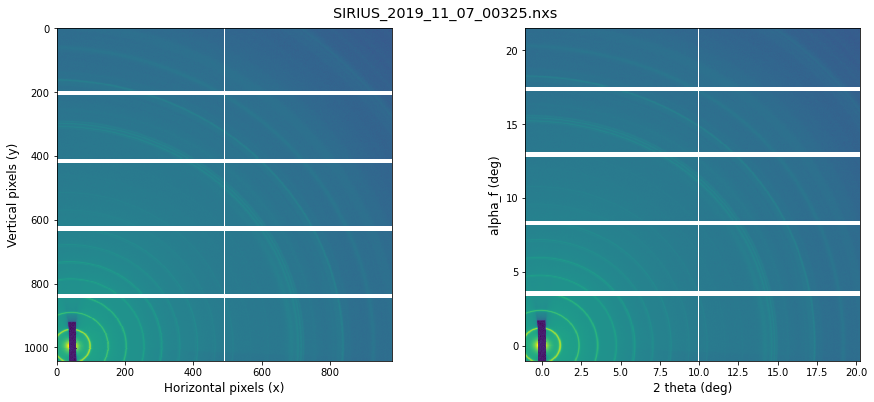

	. Original matrix saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.mat
 
	. Tiff saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.tiff
 


In [97]:
Extract_GIXS(
    nxs_filename='SIRIUS_2019_11_07_00325.nxs', working_dir=expt.working_dir, recording_dir=expt.recording_dir,
                 logz=True, distance=expt.distance, gamma = expt.gamma, delta = expt.delta,
                 pixel_PONI_x=expt.pixel_PONI_x, pixel_PONI_y=expt.pixel_PONI_y, pixel_size=expt.pixel_size,
                 show_data_stamps=True, show_saved_data=True, plot_twotheta_alphaf=True)

 - Open Nexus Data File :
	/Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/recording/SIRIUS_2019_11_07_00325.nxs
	. Number of data points:  11
	. Available Counters:
		 0  ------->  hu36energy
		 1  ------->  current
		 2  ------->  mon2
		 3  ------->  mon4
		 4  ------->  camxdirect
		 5  ------->  pilatus
		 6  ------->  pilatusroi1
		 7  ------->  integration_time
		 8  ------->  sensorsRelTimestamps
		 9  ------->  sensorsTimestamps
	. Pilatus data found, (column 5, alias pilatus)
 	. No gamma found, taking gamma =  0                                 
 	. No delta found, taking delta =-11.58 
	. For more details on the geometry, see:
	 	 -Fig.2 in doi:10.1107/S0909049512022017
	 	 -Slide 4 in http://gisaxs.com/files/Strzalka.pdf


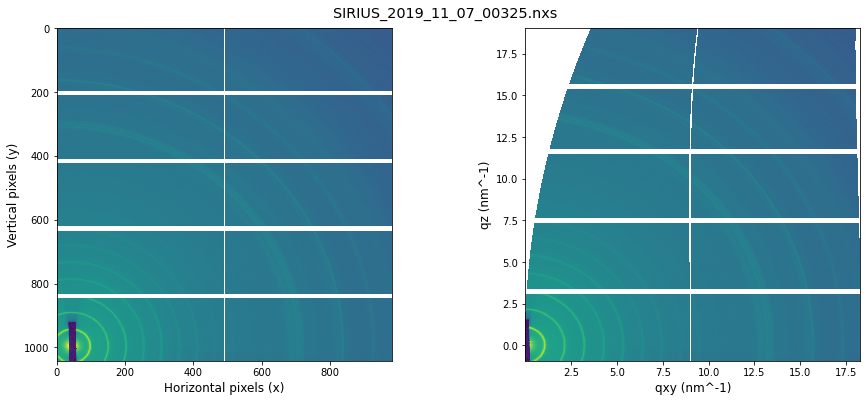

	. Original matrix saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.mat
 
	. Tiff saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.tiff
 


In [98]:
Extract_GIXS(
    nxs_filename='SIRIUS_2019_11_07_00325.nxs', working_dir=expt.working_dir, recording_dir=expt.recording_dir,
                 logz=True, wavelength=expt.wavelength, thetai=expt.thetai, distance=expt.distance, gamma = expt.gamma, delta = expt.delta,
                 pixel_PONI_x=expt.pixel_PONI_x, pixel_PONI_y=expt.pixel_PONI_y, pixel_size=expt.pixel_size,
                 show_data_stamps=True, show_saved_data=True, plot_qxy_qz=True)

 - Open Nexus Data File :
	/Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/recording/SIRIUS_2019_11_07_00325.nxs
	. Number of data points:  11
	. Available Counters:
		 0  ------->  hu36energy
		 1  ------->  current
		 2  ------->  mon2
		 3  ------->  mon4
		 4  ------->  camxdirect
		 5  ------->  pilatus
		 6  ------->  pilatusroi1
		 7  ------->  integration_time
		 8  ------->  sensorsRelTimestamps
		 9  ------->  sensorsTimestamps
	. Pilatus data found, (column 5, alias pilatus)
 	. No gamma found, taking gamma =  0                                 
 	. No delta found, taking delta =-11.58 
	. For more details on the geometry, see:
	 	 -Fig.2 in doi:10.1107/S0909049512022017
	 	 -Slide 4 in http://gisaxs.com/files/Strzalka.pdf


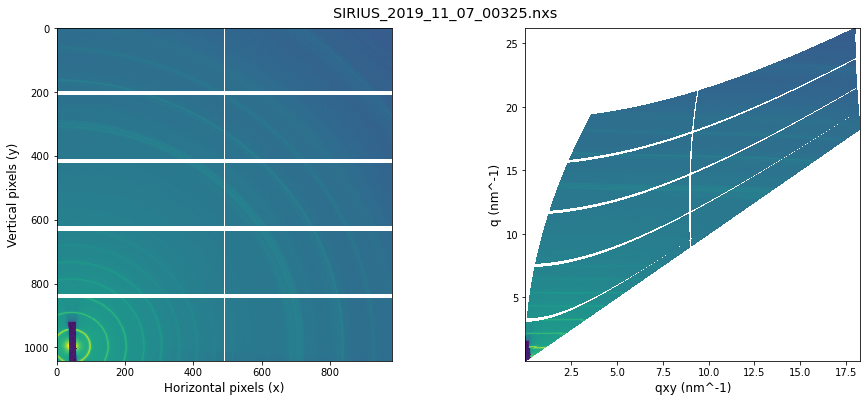

	. Original matrix saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.mat
 
	. Tiff saved in:
		 /Users/arnaudhemmerle/Documents/Recherche/Analysis/JupyLabBook/working/SIRIUS_2019_11_07_00325.tiff
 


In [103]:
Extract_GIXS(
    nxs_filename='SIRIUS_2019_11_07_00325.nxs', working_dir=expt.working_dir, recording_dir=expt.recording_dir,
                 logz=True, wavelength=expt.wavelength, thetai=expt.thetai, distance=expt.distance, gamma = expt.gamma, delta = expt.delta,
                 pixel_PONI_x=expt.pixel_PONI_x, pixel_PONI_y=expt.pixel_PONI_y, pixel_size=expt.pixel_size,
                 show_data_stamps=True, show_saved_data=True, plot_qxy_q=True)